In [1]:
import codigo
from codigo import utils
from codigo import model_utils

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pickle import dump

%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importar Dataset depurado

In [3]:
df_Inicial = pd.read_csv(r'dataset/generado/datasetDepurado.csv')

# Revisamos las columnas que contiene el Dataset

In [4]:
df_Inicial.head()

,ID,Date,Glucose level
0,LIB193263,2020-06-09 19:08:00,99.0
1,LIB193263,2020-06-09 19:23:00,92.0
2,LIB193263,2020-06-09 19:38:00,86.0
3,LIB193263,2020-06-09 19:53:00,85.0
4,LIB193263,2020-06-09 20:08:00,85.0


In [5]:
df_Inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966685 entries, 0 to 2966684
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ID             object 
 1   Date           object 
 2   Glucose level  float64
dtypes: float64(1), object(2)
memory usage: 67.9+ MB


### Cambiamos el formato de la columna Date de object a datetime64

In [6]:
df_Inicial['Date']=pd.to_datetime(df_Inicial['Date'])

In [7]:
df_Inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966685 entries, 0 to 2966684
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ID             object        
 1   Date           datetime64[ns]
 2   Glucose level  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.9+ MB


In [8]:
df_Inicial['Date'].min()

Timestamp('2018-01-06 00:31:00')

In [9]:
df_Inicial['Date'].max()

Timestamp('2022-03-20 23:58:00')

# Seleccionar los pacientes para evaluación

In [10]:
dfPacienteCount= pd.DataFrame(df_Inicial.ID.value_counts().sort_values(ascending=False))
dfPacienteCount.columns = ['Freq']
dfPacienteCount

,Freq
LIB193277,114563
LIB193385,112924
LIB193307,104043
LIB193309,77285
LIB193367,76611
...,...
LIB193366,1287
LIB193398,1253
LIB193283,1098
LIB193365,1057


In [11]:
pacientesNoDeseados=['LIB193321']
dfPacienteCount=dfPacienteCount[~dfPacienteCount.index.isin(pacientesNoDeseados)]

In [12]:
dfPacienteCount

,Freq
LIB193277,114563
LIB193385,112924
LIB193307,104043
LIB193309,77285
LIB193367,76611
...,...
LIB193282,1808
LIB193366,1287
LIB193398,1253
LIB193283,1098


<AxesSubplot: >

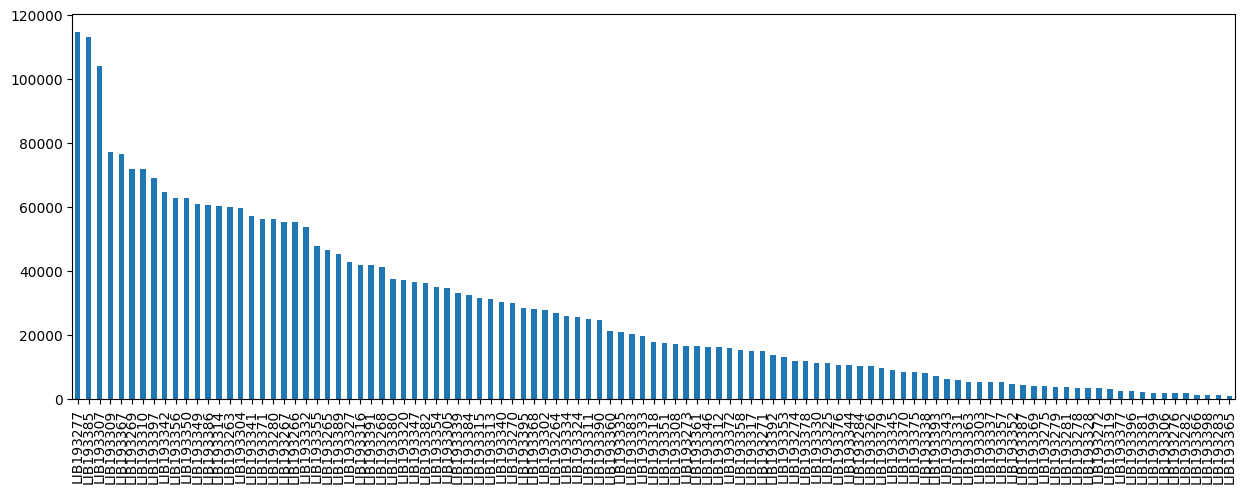

In [13]:
dfPacienteCount['Freq'].plot.bar(figsize=(15, 5))

In [14]:
dfPacienteCount.describe()

,Freq
count,107.000000
mean,27726.009346
std,25694.131765
min,1057.000000
25%,6717.000000
50%,17889.000000
75%,41868.000000
max,114563.000000


In [15]:
train_share = 1
val_share = 0
lag=30
n_ahead=1
formato='%Y-%m-%d %H:%M:%S'
min=15

strMin=str(min)+'min'

In [16]:
features=['Glucose level','hour','min','pod_id','level_id','level_label']
featuresObj=['Glucose level','hour','min','pod_id','level_id']

In [17]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))
scalerHours = load(open('dataset/generado/scalerHours.scaler', 'rb'))
scalerMin = load(open('dataset/generado/scalerMin.scaler', 'rb'))
scalerPodId = load(open('dataset/generado/scalerPodId.scaler', 'rb'))
scalerLevelId = load(open('dataset/generado/scalerLevelId.scaler', 'rb'))

## Pacientes del Q1

In [18]:
dfPacienteCount[dfPacienteCount['Freq'].between(0, 6717)]

,Freq
LIB193343,6323
LIB193331,6026
LIB193363,5362
LIB193303,5283
LIB193337,5187
LIB193357,5169
LIB193352,4775
LIB193387,4490
LIB193369,4170
LIB193275,4095


'LIB193399' tiene 1913 muestras

In [19]:
ID_Paciente=pq1='LIB193399'

In [20]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [21]:
dfpaciente

,ID,Date,Glucose level
2964772,LIB193399,2020-09-30 18:15:00,105.0
2964773,LIB193399,2020-09-30 18:30:00,101.0
2964774,LIB193399,2020-09-30 18:45:00,98.0
2964775,LIB193399,2020-09-30 19:00:00,99.0
2964776,LIB193399,2020-09-30 19:15:00,108.0
...,...,...,...
2966680,LIB193399,2020-10-20 20:50:00,83.0
2966681,LIB193399,2020-10-20 21:05:00,76.0
2966682,LIB193399,2020-10-20 21:20:00,67.0
2966683,LIB193399,2020-10-20 21:35:00,63.0


In [22]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [23]:
dfGenPaciente

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-09-30 18:15:00,105.0,18,15,4,0,euglycemia
2020-09-30 18:30:00,101.0,18,30,4,0,euglycemia
2020-09-30 18:45:00,98.0,18,45,4,0,euglycemia
2020-09-30 19:00:00,99.0,19,0,4,0,euglycemia
2020-09-30 19:15:00,108.0,19,15,4,0,euglycemia
...,...,...,...,...,...,...
2020-10-20 20:45:00,83.0,20,45,4,0,euglycemia
2020-10-20 21:00:00,76.0,21,0,5,0,euglycemia
2020-10-20 21:15:00,67.0,21,15,5,-1,hypoglycemia


In [24]:
dfGenPacienteScaled

,Glucose level,hour,min,pod_id,level_id
Date,,,,,
2020-09-30 18:15:00,0.141304,0.782609,0.254237,0.6,0.5
2020-09-30 18:30:00,0.132609,0.782609,0.508475,0.6,0.5
2020-09-30 18:45:00,0.126087,0.782609,0.762712,0.6,0.5
2020-09-30 19:00:00,0.128261,0.826087,0.000000,0.6,0.5
2020-09-30 19:15:00,0.147826,0.826087,0.254237,0.6,0.5
...,...,...,...,...,...
2020-10-20 20:45:00,0.093478,0.869565,0.762712,0.6,0.5
2020-10-20 21:00:00,0.078261,0.913043,0.000000,0.8,0.5
2020-10-20 21:15:00,0.058696,0.913043,0.254237,0.8,0.0


### Análisis del Paciente 1: ID: LIB193399

<AxesSubplot: ylabel='level_label'>

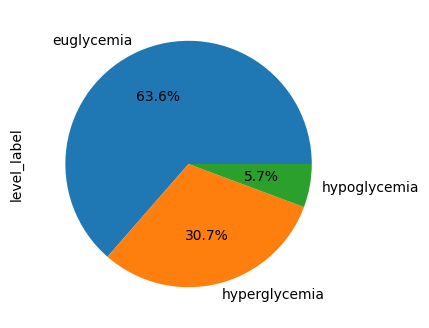

In [25]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

## Pacientes del Q2

In [26]:
dfPacienteCount[dfPacienteCount['Freq'].between(6717,17889)]

,Freq
LIB193318,17889
LIB193351,17599
LIB193308,17178
LIB193273,16575
LIB193361,16448
LIB193346,16213
LIB193312,16155
LIB193372,15782
LIB193358,15146
LIB193317,14896


'LIB193353' tiene 13083 muestras

In [27]:
ID_Paciente=pq2='LIB193353'

In [28]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [29]:
dfpaciente

,ID,Date,Glucose level
1967092,LIB193353,2021-04-20 18:25:00,180.0
1967093,LIB193353,2021-04-20 18:40:00,176.0
1967094,LIB193353,2021-04-20 18:55:00,178.0
1967095,LIB193353,2021-04-20 19:11:00,180.0
1967096,LIB193353,2021-04-20 19:25:00,172.0
...,...,...,...
1980170,LIB193353,2021-10-19 10:15:00,116.0
1980171,LIB193353,2021-10-19 10:30:00,117.0
1980172,LIB193353,2021-10-19 10:45:00,114.0
1980173,LIB193353,2021-10-19 11:00:00,101.0


In [30]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [31]:
dfGenPaciente

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-04-20 18:15:00,180.0,18,15,4,0,euglycemia
2021-04-20 18:30:00,176.0,18,30,4,0,euglycemia
2021-04-20 18:45:00,178.0,18,45,4,0,euglycemia
2021-04-20 19:00:00,180.0,19,0,4,0,euglycemia
2021-04-20 19:15:00,172.0,19,15,4,0,euglycemia
...,...,...,...,...,...,...
2021-10-19 10:15:00,116.0,10,15,2,0,euglycemia
2021-10-19 10:30:00,117.0,10,30,2,0,euglycemia
2021-10-19 10:45:00,114.0,10,45,2,0,euglycemia


In [32]:
dfGenPacienteScaled

,Glucose level,hour,min,pod_id,level_id
Date,,,,,
2021-04-20 18:15:00,0.304348,0.782609,0.254237,0.6,0.5
2021-04-20 18:30:00,0.295652,0.782609,0.508475,0.6,0.5
2021-04-20 18:45:00,0.300000,0.782609,0.762712,0.6,0.5
2021-04-20 19:00:00,0.304348,0.826087,0.000000,0.6,0.5
2021-04-20 19:15:00,0.286957,0.826087,0.254237,0.6,0.5
...,...,...,...,...,...
2021-10-19 10:15:00,0.165217,0.434783,0.254237,0.2,0.5
2021-10-19 10:30:00,0.167391,0.434783,0.508475,0.2,0.5
2021-10-19 10:45:00,0.160870,0.434783,0.762712,0.2,0.5


### Análisis del Paciente 2: ID: LIB193353

<AxesSubplot: ylabel='level_label'>

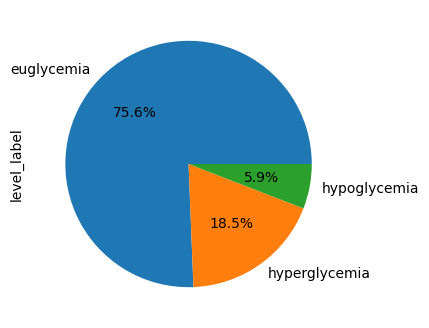

In [33]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

## Pacientes del Q3

In [34]:
dfPacienteCount[dfPacienteCount['Freq'].between(17889,41868)]

,Freq
LIB193391,41790
LIB193268,41073
LIB193380,37553
LIB193320,37172
LIB193347,36456
LIB193382,36130
LIB193354,35086
LIB193305,34549
LIB193339,33071
LIB193384,32368


'LIB193315' tiene 31592 muestras

In [35]:
ID_Paciente=pq3='LIB193315'

In [36]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [37]:
dfpaciente

,ID,Date,Glucose level
1166570,LIB193315,2021-03-09 12:04:00,99.0
1166571,LIB193315,2021-03-09 12:19:00,89.0
1166572,LIB193315,2021-03-09 12:34:00,80.0
1166573,LIB193315,2021-03-09 12:49:00,87.0
1166574,LIB193315,2021-03-09 13:05:00,102.0
...,...,...,...
1198157,LIB193315,2022-03-18 06:11:00,188.0
1198158,LIB193315,2022-03-18 06:26:00,182.0
1198159,LIB193315,2022-03-18 06:41:00,171.0
1198160,LIB193315,2022-03-18 06:56:00,167.0


In [38]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [39]:
dfGenPaciente

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2021-03-09 12:00:00,99.0,12,0,2,0,euglycemia
2021-03-09 12:15:00,89.0,12,15,2,0,euglycemia
2021-03-09 12:30:00,80.0,12,30,2,0,euglycemia
2021-03-09 12:45:00,87.0,12,45,2,0,euglycemia
2021-03-09 13:00:00,102.0,13,0,3,0,euglycemia
...,...,...,...,...,...,...
2022-03-18 06:00:00,188.0,6,0,1,1,hyperglycemia
2022-03-18 06:15:00,182.0,6,15,1,1,hyperglycemia
2022-03-18 06:30:00,171.0,6,30,1,0,euglycemia


In [40]:
dfGenPacienteScaled

,Glucose level,hour,min,pod_id,level_id
Date,,,,,
2021-03-09 12:00:00,0.128261,0.521739,0.000000,0.2,0.5
2021-03-09 12:15:00,0.106522,0.521739,0.254237,0.2,0.5
2021-03-09 12:30:00,0.086957,0.521739,0.508475,0.2,0.5
2021-03-09 12:45:00,0.102174,0.521739,0.762712,0.2,0.5
2021-03-09 13:00:00,0.134783,0.565217,0.000000,0.4,0.5
...,...,...,...,...,...
2022-03-18 06:00:00,0.321739,0.260870,0.000000,0.0,1.0
2022-03-18 06:15:00,0.308696,0.260870,0.254237,0.0,1.0
2022-03-18 06:30:00,0.284783,0.260870,0.508475,0.0,0.5


### Análisis del Paciente 3: ID: LIB193315

<AxesSubplot: ylabel='level_label'>

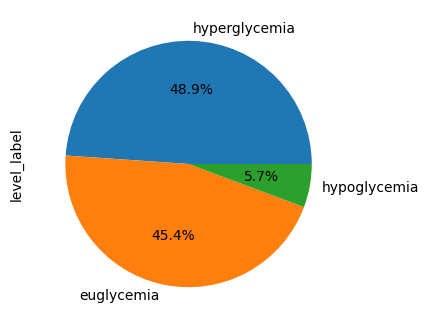

In [41]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

## Pacientes del Q4

In [42]:
dfPacienteCount[dfPacienteCount['Freq']>41868]

,Freq
LIB193277,114563
LIB193385,112924
LIB193307,104043
LIB193309,77285
LIB193367,76611
LIB193269,71853
LIB193310,71764
LIB193397,68945
LIB193342,64666
LIB193356,62847


'LIB193304' tiene 59786 muestras

In [43]:
ID_Paciente=pq4='LIB193304'

In [44]:
dfpaciente=df_Inicial[df_Inicial['ID'] == ID_Paciente]

In [45]:
dfpaciente

,ID,Date,Glucose level
667394,LIB193304,2020-06-10 17:59:00,192.0
667395,LIB193304,2020-06-10 18:14:00,187.0
667396,LIB193304,2020-06-10 18:29:00,178.0
667397,LIB193304,2020-06-10 18:44:00,170.0
667398,LIB193304,2020-06-10 19:00:00,153.0
...,...,...,...
727175,LIB193304,2022-03-18 22:23:00,100.0
727176,LIB193304,2022-03-18 22:38:00,89.0
727177,LIB193304,2022-03-18 22:53:00,92.0
727178,LIB193304,2022-03-18 23:08:00,106.0


In [46]:
dfGenPaciente,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,features,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=False)
dfGenPacienteScaled,array_Xtrain,array_Ytrain,array_Xval,array_Yval,array_Xtest,array_Ytest=model_utils.GenDataSet(dfpaciente,featuresObj,[ID_Paciente],min,train_share,val_share,lag,n_ahead,scalerHours,scalerMin,scalerGlucosa,scalerPodId,scalerLevelId,fillNullData=True,resample=True,normalized=True)

In [47]:
dfGenPaciente

,Glucose level,hour,min,pod_id,level_id,level_label
Date,,,,,,
2020-06-10 17:45:00,192.0,17,45,4,1,hyperglycemia
2020-06-10 18:00:00,187.0,18,0,4,1,hyperglycemia
2020-06-10 18:15:00,178.0,18,15,4,0,euglycemia
2020-06-10 18:30:00,170.0,18,30,4,0,euglycemia
2020-06-10 18:45:00,161.5,18,45,4,0,euglycemia
...,...,...,...,...,...,...
2022-03-18 22:15:00,100.0,22,15,5,0,euglycemia
2022-03-18 22:30:00,89.0,22,30,5,0,euglycemia
2022-03-18 22:45:00,92.0,22,45,5,0,euglycemia


In [48]:
dfGenPacienteScaled

,Glucose level,hour,min,pod_id,level_id
Date,,,,,
2020-06-10 17:45:00,0.330435,0.739130,0.762712,0.6,1.0
2020-06-10 18:00:00,0.319565,0.782609,0.000000,0.6,1.0
2020-06-10 18:15:00,0.300000,0.782609,0.254237,0.6,0.5
2020-06-10 18:30:00,0.282609,0.782609,0.508475,0.6,0.5
2020-06-10 18:45:00,0.264130,0.782609,0.762712,0.6,0.5
...,...,...,...,...,...
2022-03-18 22:15:00,0.130435,0.956522,0.254237,0.8,0.5
2022-03-18 22:30:00,0.106522,0.956522,0.508475,0.8,0.5
2022-03-18 22:45:00,0.113043,0.956522,0.762712,0.8,0.5


### Análisis del Paciente 4: ID: LIB193341

<AxesSubplot: ylabel='level_label'>

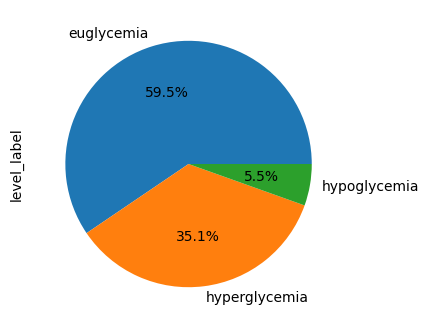

In [49]:
dfGenPaciente['level_label'].value_counts().plot.pie(y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))

## Guardamos los IDs de los pacientes para modelo general

In [50]:
dfPacienteCount

,Freq
LIB193277,114563
LIB193385,112924
LIB193307,104043
LIB193309,77285
LIB193367,76611
...,...
LIB193282,1808
LIB193366,1287
LIB193398,1253
LIB193283,1098


In [51]:
pacientesEvaluacion=[pq1,pq2,pq3,pq4]
dfPacienteCount=dfPacienteCount[~dfPacienteCount.index.isin(pacientesEvaluacion)]
dfPacienteCount['ID']=dfPacienteCount.index
dfPacienteCount

,Freq,ID
LIB193277,114563,LIB193277
LIB193385,112924,LIB193385
LIB193307,104043,LIB193307
LIB193309,77285,LIB193309
LIB193367,76611,LIB193367
...,...,...
LIB193282,1808,LIB193282
LIB193366,1287,LIB193366
LIB193398,1253,LIB193398
LIB193283,1098,LIB193283


In [52]:
dfPacienteCount['ID'].to_csv('dataset/generado/IDs_ModelGen.csv', index=False) 